In [1]:
import tsm

In [2]:
nome_arquivo = tsm.download(data_string='01-10-2021')

Erro 404. oisst-avhrr-v02r01.20211001.nc ainda não disponível
oisst-avhrr-v02r01.20211001_preliminary.nc [ok]


## LEITURA DO ARQUIVO

In [4]:
import xarray as xr
import os

caminho_base = os.getcwd()

In [6]:
tsm_nc = xr.open_dataset(f'{caminho_base}/downloads/{nome_arquivo}')

In [14]:
temperatura = tsm_nc.sst

In [15]:
from xarray import Dataset
def preparar_para_recorte(dataset:Dataset, crs="epsg:4326", xdim="lon", ydim="lat") -> Dataset:
    """Ajusta coordenadas e dados para o recorte da chuva.
    
    Args:
        dataset (Dataset): Dado a ser recortado pelo shapefile
        crs (str, optional): Projeção cartográfica. Defaults to "epsg:4326".
        xdim (str, optional): Nome da dimensão "longitude" no dataset. Defaults to "lon".
        ydim (str, optional): Nome da dimensão "latitude" no dataset. Defaults to "lat".
    Returns:
        Dataset: Dados tratados para recorte
    """
    dataset = dataset.assign_coords(lon=(((dataset.lon + 180) % 360) - 180)).sortby(xdim)
    dataset = dataset.rio.set_spatial_dims(x_dim=xdim, y_dim=ydim) 
    dataset = dataset.rio.write_crs(crs)
    return dataset

temperatura_tratada = preparar_para_recorte(temperatura)

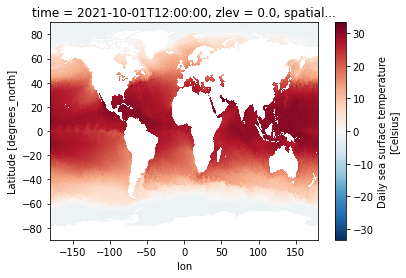

In [52]:
temperatura_tratada.plot()

## Recorte Niño 1+2 e Niño 3.4

In [43]:
# Niño 1+2 (0-10S, 90W-80W)
# Niño 3.4 (5N-5S, 170W-120W)
temperatura_nino1_2 = temperatura_tratada.sel(lon=slice(-90, -80), lat=slice(-10, 0))
temperatura_nino3_4 = temperatura_tratada.sel(lon=slice(-170, -120), lat=slice(-5, 5))

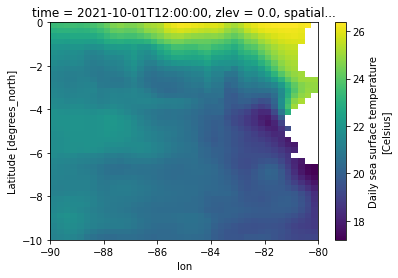

In [42]:
temperatura_nino1_2.plot()

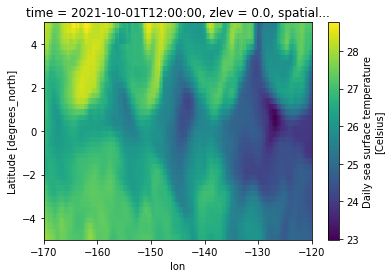

In [44]:
temperatura_nino3_4.plot()

In [49]:
valor_nino12 = float(temperatura_nino1_2.mean(dim=["lat", "lon"]).values)
valor_nino34 = float(temperatura_nino3_4.mean(dim=["lat", "lon"]).values)

In [65]:
print(f'temperatura Niño 1+2: {valor_nino12} Cº')
print(f'temperatura Niño 3.4: {valor_nino34} Cº')

temperatura Niño 1+2: 21.223512649536133 Cº
temperatura Niño 3.4: 26.192058563232422 Cº


## Recorte confluência Brasil-Malvinas

In [53]:
# Onde ocorre a CBM (63ºW - 48ºW; 43ºS - 33ºS)
temperatura_cbm = temperatura_tratada.sel(lon=slice(-63, -48), lat=slice(-43, -33))

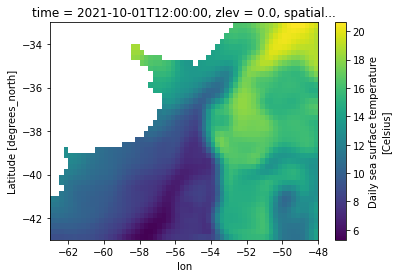

In [55]:
temperatura_cbm.plot()

In [56]:
valor_nino_cbm = float(temperatura_cbm.mean(dim=["lat", "lon"]).values)

In [64]:
print(f'temperatura Confluência Brasil-Malvinas: {valor_nino_cbm} Cº')

temperatura Confluência Brasil-Malvinas: 12.660136222839355 Cº


## Salvando em csv

In [66]:
import pandas as pd

In [69]:
dicionario = {'nino12':[valor_nino12],
             'nino34':[valor_nino34],
             'cbm':[valor_nino_cbm]
             }

In [70]:
df=pd.DataFrame.from_dict(dicionario)

In [75]:
df.to_csv('temperaturas.csv',index=False)